In [45]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


pd.options.mode.chained_assignment = None  # default='warn'

In [74]:
df_all = pd.read_csv('dataset/recovery-news-data.csv')

In [75]:
df_all['reliability'][df_all.reliability == 1] = 'true'
df_all['reliability'][df_all.reliability == 0] = 'fake'

In [76]:
print("Wiersze:", df_all.shape[0])
print("Kolumny:", df_all.shape[1])

Wiersze: 2029
Kolumny: 12


In [77]:
df_all.sample(10)

,Unnamed: 0,news_id,url,publisher,publish_date,author,title,image,body_text,political_bias,country,reliability
136,136,136,https://www.npr.org/sections/coronavirus-live-...,National Public Radio (NPR),2020-03-23,['Scott Hensley'],"FACT CHECK: Trump Says 50,000 Could Die From Flu.",https://media.npr.org/assets/img/2020/03/23/ap...,"FACT CHECK: Trump Says 50,000 Could Die From F...",Center,USA,true
1839,1839,1839,https://humansarefree.com/2020/05/george-soros...,Humans Are Free,2020-05-22,[],George Soros Views The COVID-19 Plandemic As A...,https://humansarefree.com/wp-content/uploads/2...,George Soros referred to the coronavirus ordea...,NaN,USA,fake
1235,1235,1235,https://www.pbs.org/newshour/show/keystone-pip...,PBS NewsHour,2020-05-17,"['Ivette Feliciano', 'Zachary Green']",Keystone pipeline project proceeds amidst COVI...,https://d3i6fh83elv35t.cloudfront.net/static/2...,Hari Sreenivasan:\n\nWhen the Trump administra...,Center,USA,true
1286,1286,1286,http://uk.reuters.com/article/us-health-corona...,Reuters,2020-05-18,['Tim Hepher'],"As flying returns, jetmakers seek to quell fea...",https://s1.reutersmedia.net/resources/r/?m=02&...,PARIS (Reuters) - Jet manufacturers and airlin...,Center,UK,true
1312,1312,1312,https://www.politico.eu/article/coronavirus-eu...,Politico,2020-05-18,"['Cornelius Hirsch', 'Arnau Busquets Guàrdia']",By the numbers: Europe on the move again,https://www.politico.eu/wp-content/uploads/202...,Presidential reelection campaigns are generall...,Center,USA,true
865,865,865,https://www.businessinsider.com/trump-coronavi...,Business Insider,2020-05-13,['Linette Lopez'],Trump's plan to get through coronavirus comes ...,https://i.insider.com/5ebae5d31441920e5055daaa...,"President Donald Trump, unable to get the nove...",Left-center,USA,true
183,183,183,https://www.npr.org/sections/goatsandsoda/2020...,National Public Radio (NPR),2020-03-28,['Yuhan Xu'],A Reward Of Liquor For Coronavirus Heroes In C...,https://media.npr.org/assets/img/2020/03/27/ge...,A Reward Of Liquor For Coronavirus Heroes In C...,Center,USA,true
420,420,420,https://www.theverge.com/2020/4/24/21234936/am...,The Verge,2020-04-24,['Nick Statt'],Amazon extends hourly wage increase for wareho...,https://cdn.vox-cdn.com/thumbor/fhTpM7RsSd5QYN...,Amazon is extending its increase in the hourly...,Left-center,USA,true
1231,1231,1231,https://www.cnbc.com/2020/05/16/angel-soft-vp-...,CNBC,2020-05-16,['Jade Scipioni'],Angel Soft executive: 'My own mother wanted to...,https://image.cnbcfm.com/api/v1/image/10651065...,"Prior to the Covid-19 pandemic, no one ever as...",Left-center,USA,true
442,442,442,https://chicago.suntimes.com/coronavirus/2020/...,Chicago Sun-Times,2020-04-26,['Jake Wittich'],South Side LGBTQ pride festival moves online a...,https://cdn.vox-cdn.com/thumbor/jofXxnL9cdylYx...,Organizers of Pride South Side are bringing Ch...,Left-center,USA,true


In [83]:
# Filtr, który wyekstraktuje tylko newsy pochodzące z USA
df_all = df_all[df_all['country']=='USA']

Należy sprawadzić, czy w kolumnie "content" znajdują się jakieś puste wartości lub duplikaty.

In [84]:
nan = df_all['body_text'].isnull().sum(axis = 0)
print("Liczba NaN w kolumnie 'content':",(nan))

unique = df_all['body_text'].nunique()
print("Liczba duplikatów:",(len(df_all) - unique))
df_all = df_all.drop_duplicates(subset='body_text', keep="last")

#liczba duplikatów
print("Liczba duplikatów po operacji:",(len(df_all['body_text']) - df_all['body_text'].nunique()))
print("Liczba wierszy po operacji:", len(df_all))

Liczba NaN w kolumnie 'content': 0
Liczba duplikatów: 0
Liczba duplikatów po operacji: 0
Liczba wierszy po operacji: 1590


In [81]:
print("Liczba wierszy po operacji:", len(df_all))
print("Kolumny:", df_all.shape[1])

Liczba wierszy po operacji: 1590
Kolumny: 12


W kolumnie "publisher" można znaleźć nazwy gazet lub portali, których opublikowane newsy znalazły się w bazie reCOVery.

In [82]:
df_all['publisher'][df_all.reliability == 'true'].value_counts()

Chicago Sun-Times              321
Business Insider               158
The Verge                      139
USA Today                      107
National Public Radio (NPR)     92
The New York Times              67
CBS News                        67
CNBC                            46
Yahoo! News                     36
The Washington Post             33
The Detroit News                28
Slate                           24
Politico                        23
Los Angeles Daily News          20
ABC News                        18
The Mercury News                17
The Atlantic                    13
The New Yorker                  12
PBS NewsHour                    10
FiveThirtyEight                  2
Washington Monthly               1
Name: publisher, dtype: int64

In [54]:
df_all['publisher'][df_all.reliability == 'fake'].value_counts()

WorldHealth.Net         75
American Thinker        32
Heartland Institute     30
Drudge Report           26
FrontPage Magazine      25
Natural News            23
Health Impact News      19
InfoWars                16
DC Dirty Laundry        15
Humans Are Free         14
The Gateway Pundit      13
GreenMedInfo            11
True Pundit             11
Geller Report News      10
Health Nut News         10
Big League Politics      8
Collective Evolution     5
Bipartisan Report        4
The Mind Unleashed       4
News Punch               3
Waking Times             1
Name: publisher, dtype: int64

true    1234
fake     355
Name: reliability, dtype: int64


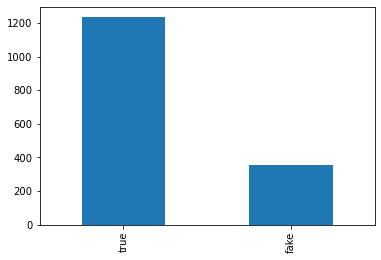

In [55]:
df_all['reliability'].value_counts(normalize=False).plot(kind='bar');
print(df_all['reliability'].value_counts())

W zbiorze reCOVery znajduje się kolumna 'political_bias', która informuje o nacechowaniu politycznym danego newsa

In [56]:
df_all['political_bias'].value_counts()

Left-center      849
Center           234
Left             103
Extreme right    101
Right             82
Right-center      48
Extreme left       4
Name: political_bias, dtype: int64

In [57]:
# Usunięcie kolumn, które nie będą już potrzebne w dalszej analizie
df_all['text'] = df_all['body_text']
df_all['target'] = df_all['reliability']
df = df_all[['target', 'text']]

# Podstawowa normalizacja - zmiana tekstu na małe litery
df['text_norm'] = df['text'].str.lower()

df.head(5)

,target,text,text_norm
0,true,\nA novel respiratory virus that originated in...,\na novel respiratory virus that originated in...
1,true,Chinese Health Officials: More Die From Newly ...,chinese health officials: more die from newly ...
2,true,Public health experts around the globe are scr...,public health experts around the globe are scr...
3,fake,The first two coronavirus cases in Europe have...,the first two coronavirus cases in europe have...
4,true,"A new coronavirus appeared in Wuhan, China, at...","a new coronavirus appeared in wuhan, china, at..."


In [58]:
# Policzmy, ile mamy wszystkich Tokenów w Korpusie
tokens_set = set()
df['text_norm'].str.split(" ").map(tokens_set.update)
print(len(tokens_set))

115393


In [70]:
# 30 najczęściej występujących słów to stop words

cntr = Counter()
df["text_norm"].str.split(" ").map(cntr.update)
cntr.most_common(n=20)

[('the', 71701),
 ('to', 43515),
 ('and', 35868),
 ('of', 35752),
 ('a', 28780),
 ('in', 26072),
 ('that', 16581),
 ('for', 14575),
 ('is', 13205),
 ('on', 10553),
 ('are', 9556),
 ('with', 9078),
 ('have', 8703),
 ('as', 8267),
 ('be', 7964),
 ('at', 7370),
 ('it', 7043),
 ('from', 6406),
 ('was', 6322),
 ('has', 6091)]

In [71]:
# 30 najczęściej występujących tokenów po usunięciu stop words

stop = stopwords.words('english')
cntr2 = Counter()
df['text_nostop'] = df['text_norm'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df["text_nostop"].str.split(" ").map(cntr2.update)
cntr2.most_common(n=30)

[('people', 4211),
 ('said', 4065),
 ('—', 3790),
 ('new', 3705),
 ('coronavirus', 3695),
 ('one', 2780),
 ('also', 2774),
 ('health', 2766),
 ('would', 2679),
 ('may', 2609),
 ('covid-19', 2450),
 ('like', 2160),
 ('said.', 2121),
 ('could', 2030),
 ('many', 2011),
 ('get', 1866),
 ('even', 1814),
 ('virus', 1611),
 ('state', 1603),
 ('first', 1567),
 ('time', 1523),
 ('two', 1515),
 ('it’s', 1486),
 ('going', 1480),
 ('public', 1452),
 ('us', 1418),
 ('trump', 1344),
 ('according', 1294),
 ('still', 1279),
 ('make', 1270)]

In [61]:
# Możemy zliczyć sumę wystąpień poszczególnych Tokenów w każdym Dokumencie i zapisać to w dodatkowej kolumnie. 
# Dzięki temu powstał uproszczony Bag of Words dla każdego dokumentu.

df["text_norm_counter"] = df["text_norm"].str.split(" ").map(lambda x: dict(Counter(x)) )
df["counter_tokens"] = df["text_norm_counter"].map(lambda x: sum(x.values()) )

In [62]:
df.sample(5)

,target,text,text_norm,text_nostop,text_norm_counter,counter_tokens
724,true,High school juniors may find themselves at a d...,high school juniors may find themselves at a d...,high school juniors may find disadvantage appl...,"{'high': 6, 'school': 8, 'juniors': 4, 'may': ...",828
395,true,As hospitals in the epicenter of New York stra...,as hospitals in the epicenter of new york stra...,hospitals epicenter new york strain handle inf...,"{'as': 4, 'hospitals': 1, 'in': 11, 'the': 20,...",451
407,true,"\nThe first pets in the United States, two cat...","\nthe first pets in the united states, two cat...","first pets united states, two cats new york st...","{' the': 1, 'first': 1, 'pets': 5, 'in': 11, '...",645
1830,fake,From the Wall Street Journal editorial board: ...,from the wall street journal editorial board: ...,wall street journal editorial board: larger tr...,"{'from': 6, 'the': 57, 'wall': 1, 'street': 1,...",919
370,fake,Fewer humans carelessly destroying their natur...,fewer humans carelessly destroying their natur...,fewer humans carelessly destroying natural hab...,"{'fewer': 3, 'humans': 2, 'carelessly': 1, 'de...",449


In [63]:
# Przyjrzyjmy się bliżej zliczaniu tokenów na przykładzie losowego newsa

rng = np.random.default_rng()
index = rng.integers(low=0, high=1589)

print('id: ', index)
print('--------------------')
print(df.loc[[index], 'text_norm'].values[0])
df.loc[[index], 'text_norm_counter'].values[0]

id:  1028
--------------------
hartford, conn. — car batteries are fading and ruinous rodents are colonizing engine compartments as the coronavirus keeps many cars parked at home.

dead batteries prompted 40% of aaa’s calls for service in april, compared with 20% in april 2019, the organization’s greater hartford spokeswoman, amy parmenter, said.

“some cars won’t last two weeks,” said paul hechenbleikner, manager of jones’ automotive service in east hartford.

car batteries are fading and ruinous rodents are colonizing engine compartments as the coronavirus keeps many cars parked at home. (photo: dreamstime / tribune news service)

some vehicles draw more electrical power while parked with the engine off. called “parasitic drain,” electrical current goes to engine computers and electronic control modules for power windows, mirrors and other accessories.

also, older car batteries fizzle faster, said don cusson, owner of cusson automotive inc. in south windsor. mechanics advise people 

{'hartford,': 1,
 'conn.': 1,
 '—': 2,
 'car': 6,
 'batteries': 4,
 'are': 4,
 'fading': 2,
 'and': 17,
 'ruinous': 2,
 'rodents': 3,
 'colonizing': 2,
 'engine': 4,
 'compartments': 2,
 'as': 7,
 'the': 31,
 'coronavirus': 2,
 'keeps': 2,
 'many': 3,
 'cars': 4,
 'parked': 3,
 'at': 7,
 'home.\n\ndead': 1,
 'prompted': 1,
 '40%': 1,
 'of': 5,
 'aaa’s': 1,
 'calls': 1,
 'for': 7,
 'service': 2,
 'in': 7,
 'april,': 1,
 'compared': 2,
 'with': 5,
 '20%': 1,
 'april': 1,
 '2019,': 1,
 'organization’s': 1,
 'greater': 1,
 'hartford': 3,
 'spokeswoman,': 1,
 'amy': 1,
 'parmenter,': 1,
 'said.\n\n“some': 1,
 'won’t': 2,
 'last': 2,
 'two': 3,
 'weeks,”': 1,
 'said': 7,
 'paul': 1,
 'hechenbleikner,': 1,
 'manager': 1,
 'jones’': 1,
 'automotive': 2,
 'east': 1,
 'hartford.\n\ncar': 1,
 'home.': 2,
 '(photo:': 1,
 'dreamstime': 1,
 '/': 1,
 'tribune': 2,
 'news': 1,
 'service)\n\nsome': 1,
 'vehicles': 1,
 'draw': 1,
 'more': 1,
 'electrical': 2,
 'power': 2,
 'while': 1,
 'off.': 1,
 'call

In [64]:
df.to_csv('recovery_dataset.csv', encoding='utf-8', index=False)
df.to_excel("recovery.xlsx")